In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
samples = pd.read_csv("./res/bike-sharing-demand/sampleSubmission.csv")
train = pd.read_csv("./res/bike-sharing-demand/train.csv")
test = pd.read_csv("./res/bike-sharing-demand/test.csv")


train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
"""
session : 계절
holiday : 공휴일 여부
workingday : 평일 여부
weather : 날씨
temp : 온도
atemp : 체감온도
humidity : 습도
windspeed : 풍속
casual : 대여 회수
registered : 등록자의 대여횟수
count : 대여횟수


10886 x 12

na는 없음
"""

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [4]:
"""
문자열 날짜 -> datetime으로 변환
"""
train["datetime"] = train.datetime.apply(pd.to_datetime)

train["year"] = train.datetime.apply(lambda x : x.year)
train["month"] = train.datetime.apply(lambda x : x.month)
train["day"] = train.datetime.apply(lambda x : x.day)
train["hour"] = train.datetime.apply(lambda x : x.hour)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [5]:
"""
casual + registered = count
-> casual, registered, datetime 열 삭제
"""

drop_col = ["casual", "registered", "datetime"]
train.drop(columns=drop_col, axis=1, inplace= True)

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#get root mean sqaured log error
def get_rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    mlse = np.sum((log_y - log_pred)**2)
    rmlse = np.sqrt(mlse)
    return rmlse

def get_rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def eval_reg(y, pred):
    rmlse = get_rmsle(y, pred)
    rmse = get_rmse(y, pred)
    mae = mean_absolute_error(y, pred)
    print("rmlse : {0:.3f}\nrmse : {1:.3f}\nmae : {2:.3f}".format(rmlse, rmse, mae))

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y = train["count"]
X = train.drop(columns=["count"], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

lr = LinearRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)

eval_reg(y_test, pred)

rmlse : 64.276
rmse : 145.491
mae : 108.554


In [8]:
"""
종속 변수 count 값을 생각하면 오차가 상당히 크게 나옴
오차가 가장 큰 경우를 비교해보자
"""
def get_top_error_data(y_test, pred, n_tops = 5):
    res = pd.DataFrame(data=y_test.values, columns=["real"])
    res["predicted"] = pred
    res["diff"] = np.abs(res["real"] - res["predicted"])
    print(res.sort_values("diff", ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real   predicted        diff
1979   834  183.352102  650.647898
1108   817  170.565929  646.434071
1344   784  180.980466  603.019534
137    948  360.735277  587.264723
1197   731  145.824577  585.175423


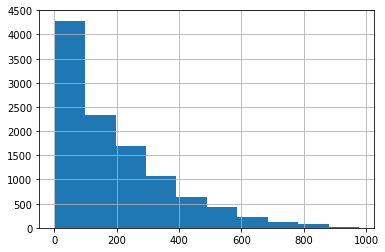

In [9]:
"""
예측  오류가 매우 큰것을 보면 타깃이 왜곡된 분포를 따르는지 확인해야함
"""
y.hist()

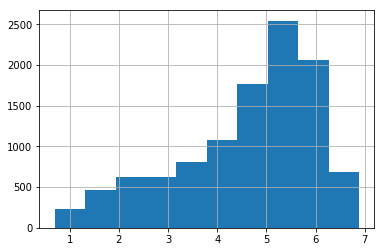

In [10]:
"""
로그 변환을 통해 y를 정규분포 형태로 바꾸어 주자
"""
y = np.log1p(y)
y.hist()

In [11]:
"""
로그 변환을 수행 후

오차 척도들이 크게 줄어들었다.
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

lr = LinearRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)

eval_reg(y_test, pred)
get_top_error_data(y_test, pred, n_tops=5)

rmlse : 13.278
rmse : 1.024
mae : 0.803
          real  predicted      diff
13    6.255750   3.169722  3.086028
1039  1.098612   4.062916  2.964304
703   0.693147   3.652817  2.959670
169   0.693147   3.637040  2.943893
408   1.386294   4.284562  2.898268


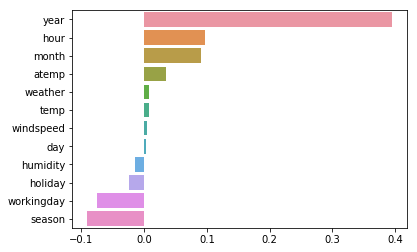

In [12]:
"""
회귀 모델에서 피처 중요도로 보았던것과는 달리

선형 회귀 모델에선 회귀 계수로 어떤 피처가 중요하게 판단되었는지 몰수 있음

"""
coeff = pd.Series(data=lr.coef_, index=X.columns)
coeff_sort = coeff.sort_values(ascending=False)
sns.barplot(x=coeff_sort.values, y=coeff_sort.index)

In [13]:
"""
상대적으로 큰 값을 갖는 year가 높은 중요도를 가진것으로 나오고 있음

year 간에는 큰 의미가 없는데도 영향을 주고 있으니

카테고리형 변수들을 인코딩 필요
"""

X_ohe = pd.get_dummies(X, columns=["year", "month", "hour", "holiday", "workingday",
                                  "season", "weather"])


X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size = 0.3)
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
eval_reg(y_test, pred)
get_top_error_data(y_test, pred, n_tops=5)

rmlse : 8.076
rmse : 0.588
mae : 0.433
          real  predicted      diff
1641  0.693147   4.132504  3.439357
1122  1.386294   4.124665  2.738370
423   0.693147   3.384599  2.691452
631   1.098612   3.673629  2.575017
1644  2.197225   4.754145  2.556920
